In [1]:
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')
import pandas as pd



In [3]:
datasets,info=tfds.load(name='beans',with_info=True,as_supervised=True,split=['test', 'train', 'validation'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteMBC1RD/beans-train.tfrecord


  0%|          | 0/1034 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteMBC1RD/beans-validation.tfrecord


  0%|          | 0/133 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteMBC1RD/beans-test.tfrecord


  0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


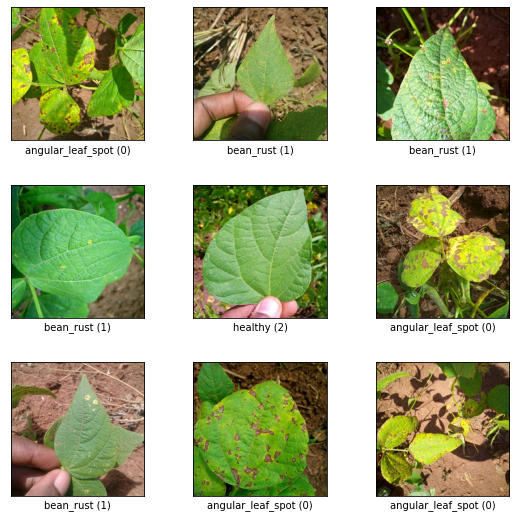

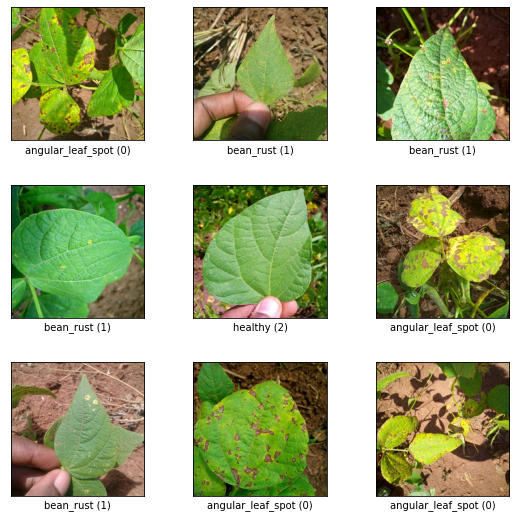

In [5]:
train,info_train=tfds.load(name='beans',with_info=True,split='test')
tfds.show_examples(info_train,train)

In [6]:
def scale(image, label):
  image=tf.cast(image,tf.float32)
  image/=255.0
  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [7]:
def get_dataset(batch_size=32):
  train_dataset_scaled=datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled=datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled=datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled,test_dataset_scaled,val_dataset_scaled

In [8]:
train_dataset,test_dataset,val_dataset=get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [56]:
len(list(datasets[1]))

1034

In [44]:
feature_extractor="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [45]:
feature_extractor_layer=hub.KerasLayer(feature_extractor,input_shape=(224,224,3))

In [46]:
feature_extractor_layer.trainable=False

In [47]:
model=tf.keras.Sequential([feature_extractor_layer,
                           tf.keras.layers.Dropout(0.3),
                          tf.keras.layers.Dense(3,activation='softmax')
                          ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

In [57]:
history=model.fit(train_dataset,epochs=20,validation_data=val_dataset)

Epoch 1/20
4/4 [==============================] - 9s 3s/step - loss: 0.3651 - acc: 0.8438 - val_loss: 0.5577 - val_acc: 0.7444
Epoch 2/20
4/4 [==============================] - 10s 3s/step - loss: 0.3477 - acc: 0.8594 - val_loss: 0.5615 - val_acc: 0.7519
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 0.3483 - acc: 0.8828 - val_loss: 0.5300 - val_acc: 0.7820
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: 0.3167 - acc: 0.8906 - val_loss: 0.5062 - val_acc: 0.7820
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.2901 - acc: 0.9219 - val_loss: 0.4927 - val_acc: 0.7895
Epoch 6/20
4/4 [==============================] - 9s 2s/step - loss: 0.3069 - acc: 0.9062 - val_loss: 0.4984 - val_acc: 0.7744
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: 0.2783 - acc: 0.9062 - val_loss: 0.4870 - val_acc: 0.7970
Epoch 8/20
4/4 [==============================] - 8s 2s/step - loss: 0.2829 - acc: 0.9297 - val_loss: 0.4756 -

In [58]:
result=model.evaluate(test_dataset)

33/33 [==============================] - 32s 970ms/step - loss: 0.4271 - acc: 0.8337


[[0.13908947 0.79916817 0.06174235]]


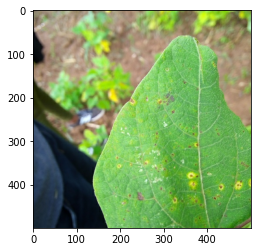

actual label:bean_rust
predicted label:bean_rust
[[0.10255241 0.86304957 0.034398  ]]


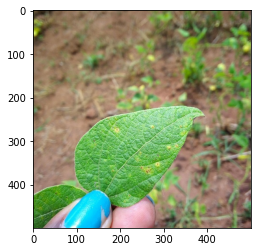

actual label:bean_rust
predicted label:bean_rust
[[0.8711069  0.09794465 0.03094839]]


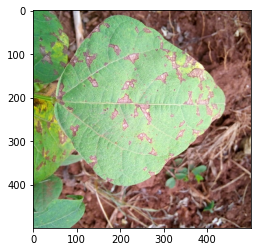

actual label:angular_leaf_spot
predicted label:angular_leaf_spot
[[0.72954416 0.24727044 0.02318547]]


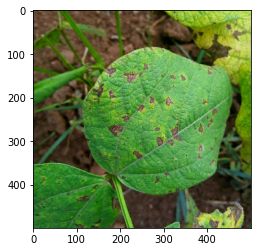

actual label:angular_leaf_spot
predicted label:angular_leaf_spot
[[0.0574906  0.93813854 0.00437081]]


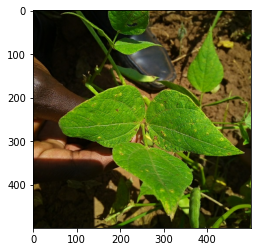

actual label:bean_rust
predicted label:bean_rust
[[0.67912614 0.30015555 0.0207183 ]]


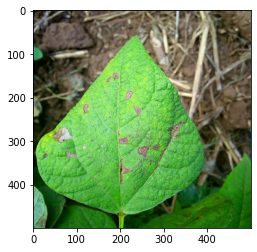

actual label:angular_leaf_spot
predicted label:angular_leaf_spot
[[0.4724511  0.5128342  0.01471476]]


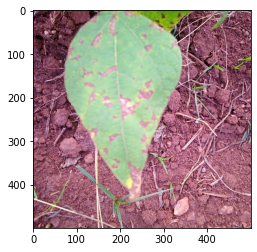

actual label:angular_leaf_spot
predicted label:bean_rust
[[0.68548656 0.1562756  0.15823787]]


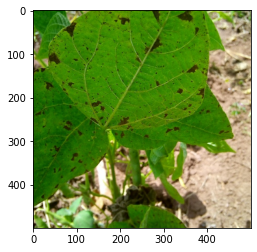

actual label:angular_leaf_spot
predicted label:angular_leaf_spot
[[0.22711655 0.72519827 0.04768512]]


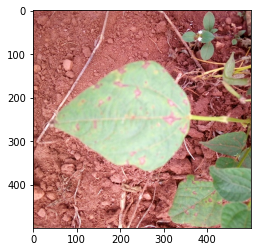

actual label:angular_leaf_spot
predicted label:bean_rust
[[0.03786027 0.9436372  0.0185025 ]]


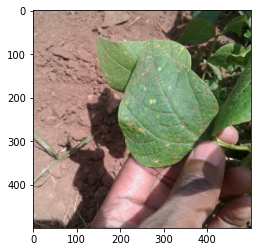

actual label:bean_rust
predicted label:bean_rust


In [59]:
for test_sample in datasets[1].take(10):
  image,label=test_sample[0],test_sample[1]
  image_scaled,label_arr=scale(test_sample[0],test_sample[1])
  image_scaled=np.expand_dims(image_scaled,axis=0)

  img=tf.keras.preprocessing.image.img_to_array(image)
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("actual label:%s"%info.features["label"].names[label.numpy()])
  print("predicted label:%s"%info.features["label"].names[np.argmax(pred)])


In [60]:
 for f0,f1 in datasets[1].map(scale).batch(200):
   y=np.argmax(f1,axis=1)
   y_pred=np.argmax(model.predict(f0),axis=1)
  # print(tf.math.confusion_matrix(labels=y_pred, num_classes=3))

In [61]:
print(tf.math.confusion_matrix(labels=y,predictions=y_pred,num_classes=3))

tf.Tensor(
[[16  4  1]
 [ 0  7  0]
 [ 0  0  6]], shape=(3, 3), dtype=int32)
